In [1]:
import random
import networkx as nx
from matplotlib import pyplot as plt
from collections import Counter
import math
from utils.plotTools import plot_qwak
import os
import ast
import numpy as np
import json
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

from scripts import load_list_from_file, write_list_to_file, load_or_generate_data, draw_graph, draw_graph_from_adjacency_matrix,print_matrix
from scripts_theoreticalHittingTime import create_transition_matrix,expected_hitting_time

In [2]:
def estimate_hitting_time( n_values, start_vertex, end_vertex, num_simulations,cw_weight=2/3, acw_weight=1/3):
    """
    Estimate the hitting time between two vertices in a list of lollipop graphs.

    Parameters:
    m_values (list): The list of m values, each representing the number of vertices in the complete graph part of a lollipop graph.
    n_values (list): The list of n values, each representing the number of vertices in the path part of a lollipop graph.
    start_vertex (int): The starting vertex for the random walk.
    end_vertex (int): The target vertex for the random walk.
    num_simulations (int): The number of simulations to perform.

    Returns:
    hitting_times (list): A list of estimated average hitting times for each lollipop graph.
    """

    hitting_times = []

    for n in  n_values:
        print(f'\nCalculatig hitting time for n={n}')
        total_steps_for_all_simulations = 0

        # Create the lollipop graph
        graph = getWeightedGraph(nx.cycle_graph(n,create_using=nx.DiGraph),cw_weight=cw_weight, acw_weight=acw_weight)
        # print(nx.adjacency_matrix(graph))
        # drawWeightedGraph(graph)
        current_node = list(graph.nodes)[start_vertex]
        if end_vertex == 'mid':
            end_node =n//2
        else:
            end_node = list(graph.nodes)[end_vertex]
        # print(f'Starting node: {current_node} \t Neighbors: {list(nx.neighbors(graph,current_node))}')
        # print(f'End node: {end_node} \t Neighbors: {list(nx.neighbors(graph,end_node))}')
        for s in range(num_simulations):
            if s==0 or s==1 or s==10 or s==25 or s==35 or s==49 or s==59 or s==69 or s==79 or s==89 or s==99:
                # print(f'----> Sample number:{s}')
                pass
            total_steps_this_simulation = 0
            current_node = list(graph.nodes)[start_vertex]
            # Loop continues until end_vertex is reached
            while current_node != end_node:
                # Choose a neighbor randomly
                # print(f'\tCurrent node: {current_node} \t Neighbors: {list(nx.neighbors(graph,current_node))}')
                neighbors = list(nx.neighbors(graph, current_node))
                if neighbors:
                    # Get the weights of the edges leading to each neighbor
                    weights = [graph[current_node][neighbor]['weight'] for neighbor in neighbors]
                    # Normalize the weights to get probabilities
                    total_weight = sum(weights)
                    probabilities = [w / total_weight for w in weights]
                    # Choose a neighbor based on the probabilities
                    current_node = random.choices(neighbors, weights=probabilities)[0]
                total_steps_this_simulation += 1

            # Accumulate the total steps for this simulation
            total_steps_for_all_simulations += total_steps_this_simulation

        # Average the total steps over the number of simulations
        average_hitting_time = total_steps_for_all_simulations / num_simulations
        hitting_times.append(average_hitting_time)

    return hitting_times

def fit_hitting_time(n,factor,c):
    hitting_times = []
    for i in n:
        hitting_times.append(c*i**factor)
       
    return hitting_times

def transform_graph(G, cw_weight=2/3, acw_weight=1/3):
    # Create a directed graph to store the transformed graph
    DG = nx.DiGraph()
    
    n = len(G.nodes)
    
    for i in range(n):
        # Clockwise neighbor
        cw_neighbor = (i + 1) % n
        # Anti-clockwise neighbor
        acw_neighbor = (n + i - 1) % n  # Use (n + i - 1) to ensure a positive index
        
        # Add directed edges with specified weights
        DG.add_edge(i, cw_neighbor, weight=cw_weight)
        DG.add_edge(i, acw_neighbor, weight=acw_weight)
        
    return DG

In [3]:
def getWeightedGraph(graph,cw_weight,acw_weight):
    revGraph = graph.reverse()
    for u,v,d in graph.edges(data=True):
        d["weight"] = cw_weight
    for u,v,d in revGraph.edges(data=True):
        d["weight"] = acw_weight
    return nx.compose(graph,revGraph)

def drawWeightedGraph(graph):
    pos = nx.circular_layout(graph)  # Changed layout to circular

    nx.draw(graph, pos, with_labels=True, connectionstyle="arc3,rad=0.2")
    
    # Edge labels with weight
    edge_labels = {(u, v): d['weight'] for u, v, d in graph.edges(data=True)}
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, label_pos=0.7)
    
    plt.show()


In [4]:
def draw_graph_with_edge_weights(graph):
    plt.figure(figsize=(8, 6))
    pos = nx.circular_layout(graph)  # Change layout algorithm here
    nx.draw(graph, pos, with_labels=True, node_size=500, node_color='lightblue', font_size=10, font_color='black')
    edge_labels = {(u, v): d['weight'] for u, v, d in graph.edges(data=True)}
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=8)
    plt.axis('off')
    plt.show()

def draw_bidirectional_graph(G):
    """
    Draws a graph with bidirectional arrows for each edge and displays the edge weights.
    
    Args:
        G (networkx.Graph): The input graph.
    """
    pos = nx.circular_layout(G)  # Change to a circular layout for a cycle graph
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', arrowsize=20, connectionstyle='arc3,rad=0.1')
    
    # Display edge weights
    edge_labels = {(u, v): d['weight'] for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    plt.show()


In [5]:
# graph = getWeightedGraph(nx.cycle_graph(10,create_using=nx.DiGraph),cw_weight=0.5, acw_weight=0.5)
# graph2 = getWeightedGraph(nx.cycle_graph(10,create_using=nx.DiGraph),cw_weight=0, acw_weight=1)
# drawWeightedGraph(graph)
# drawWeightedGraph(graph2)
# print(nx.adjacency_matrix(graph2))

In [6]:
n_range = list(range(3, 100))

samples = 100

initVertex = 0
targetVertex = 'mid'

factor = 1
c = 1

cw_weight=0.5
acw_weight=0.5

hitting_times_file = f'Datasets/HTDirectedCycle/hittingTimeDirectedCycle_N{n_range[-1]}_CWWEIGHT{cw_weight}_ACWWEIGHT{acw_weight}_FROM{initVertex}-TO{targetVertex}_S{samples}.txt'

print(f'Looking for: \n-----> {hitting_times_file}')

if os.path.exists(hitting_times_file):
    hitting_times = load_list_from_file(hitting_times_file)
    theoretical_hitting_times = fit_hitting_time(n_range,factor,c)
    print('\nFile exists!')
else:
    print('\nFile Doesnt Exist!')
    hitting_times = estimate_hitting_time(n_range,initVertex,targetVertex,samples,cw_weight,acw_weight)
    theoretical_hitting_times = fit_hitting_time(n_range,factor,c)

    write_list_to_file(hitting_times_file, hitting_times)


Looking for: 
-----> Datasets/HTDirectedCycle/hittingTimeDirectedCycle_N99_CWWEIGHT0.5_ACWWEIGHT0.5_FROM0-TOmid_S100.txt

File exists!


In [7]:
n_range = list(range(3, 100))

samples = 100

initVertex = 0
targetVertex = 'mid'

factor = 1
c = 1

cw_weight=1
acw_weight=0

hitting_times_file = f'Datasets/HTDirectedCycle/hittingTimeDirectedCycle2_N{n_range[-1]}_CWWEIGHT{cw_weight}_ACWWEIGHT{acw_weight}_FROM{initVertex}-TO{targetVertex}_S{samples}.txt'

print(f'Looking for: \n-----> {hitting_times_file}')

if os.path.exists(hitting_times_file):
    hitting_times2 = load_list_from_file(hitting_times_file)
    theoretical_hitting_times = fit_hitting_time(n_range,factor,c)
    print('\nFile exists!')
else:
    print('\nFile Doesnt Exist!')
    hitting_times2 = estimate_hitting_time(n_range,initVertex,targetVertex,samples,cw_weight,acw_weight)
    theoretical_hitting_times = fit_hitting_time(n_range,factor,c)

    write_list_to_file(hitting_times_file, hitting_times2)


Looking for: 
-----> Datasets/HTDirectedCycle/hittingTimeDirectedCycle2_N99_CWWEIGHT1_ACWWEIGHT0_FROM0-TOmid_S100.txt

File exists!


In [8]:
n_range = list(range(3, 100))

samples = 100

initVertex = 0
targetVertex = 'mid'

factor = 1
c = 1

cw_weight=0.6
acw_weight=0.40

hitting_times_file = f'Datasets/HTDirectedCycle/hittingTimeDirectedCycle3_N{n_range[-1]}_CWWEIGHT{cw_weight}_ACWWEIGHT{acw_weight}_FROM{initVertex}-TO{targetVertex}_S{samples}.txt'

print(f'Looking for: \n-----> {hitting_times_file}')

if os.path.exists(hitting_times_file):
    hitting_times3 = load_list_from_file(hitting_times_file)
    theoretical_hitting_times = fit_hitting_time(n_range,factor,c)
    print('\nFile exists!')
else:
    print('\nFile Doesnt Exist!')
    hitting_times3 = estimate_hitting_time(n_range,initVertex,targetVertex,samples,cw_weight,acw_weight)
    theoretical_hitting_times = fit_hitting_time(n_range,factor,c)

    write_list_to_file(hitting_times_file, hitting_times3)

Looking for: 
-----> Datasets/HTDirectedCycle/hittingTimeDirectedCycle3_N99_CWWEIGHT0.6_ACWWEIGHT0.4_FROM0-TOmid_S100.txt

File exists!


In [9]:
n_range = list(range(3, 100))

samples = 100

initVertex = 0
targetVertex = 'mid'

factor = 1
c = 1

cw_weight=0.55
acw_weight=0.45

hitting_times_file = f'Datasets/HTDirectedCycle/hittingTimeDirectedCycle4_N{n_range[-1]}_CWWEIGHT{cw_weight}_ACWWEIGHT{acw_weight}_FROM{initVertex}-TO{targetVertex}_S{samples}.txt'

print(f'Looking for: \n-----> {hitting_times_file}')

if os.path.exists(hitting_times_file):
    hitting_times4 = load_list_from_file(hitting_times_file)
    theoretical_hitting_times = fit_hitting_time(n_range,factor,c)
    print('\nFile exists!')
else:
    print('\nFile Doesnt Exist!')
    hitting_times4 = estimate_hitting_time(n_range,initVertex,targetVertex,samples,cw_weight,acw_weight)
    theoretical_hitting_times = fit_hitting_time(n_range,factor,c)

    write_list_to_file(hitting_times_file, hitting_times4)

Looking for: 
-----> Datasets/HTDirectedCycle/hittingTimeDirectedCycle4_N99_CWWEIGHT0.55_ACWWEIGHT0.45_FROM0-TOmid_S100.txt

File exists!


In [10]:
n_range = list(range(3, 100))

samples = 100

initVertex = 0
targetVertex = 'mid'

factor = 1
c = 1

cw_weight=0.53
acw_weight=0.47

hitting_times_file = f'Datasets/HTDirectedCycle/hittingTimeDirectedCycle5_N{n_range[-1]}_CWWEIGHT{cw_weight}_ACWWEIGHT{acw_weight}_FROM{initVertex}-TO{targetVertex}_S{samples}.txt'

print(f'Looking for: \n-----> {hitting_times_file}')

if os.path.exists(hitting_times_file):
    hitting_times5 = load_list_from_file(hitting_times_file)
    theoretical_hitting_times = fit_hitting_time(n_range,factor,c)
    print('\nFile exists!')
else:
    print('\nFile Doesnt Exist!')
    hitting_times5 = estimate_hitting_time(n_range,initVertex,targetVertex,samples,cw_weight,acw_weight)
    theoretical_hitting_times = fit_hitting_time(n_range,factor,c)

    write_list_to_file(hitting_times_file, hitting_times5)

Looking for: 
-----> Datasets/HTDirectedCycle/hittingTimeDirectedCycle5_N99_CWWEIGHT0.53_ACWWEIGHT0.47_FROM0-TOmid_S100.txt

File exists!


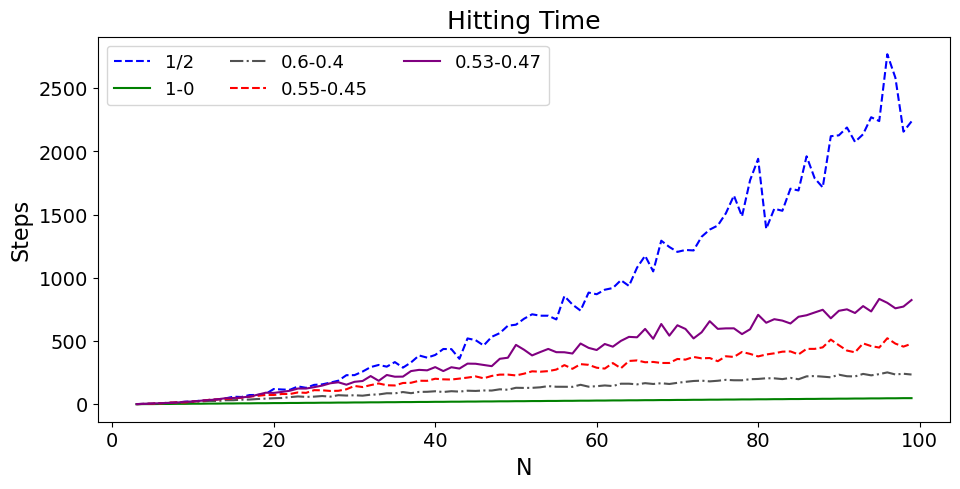

In [11]:
alphaLabelList = [r'1/2',f'1-0',f'0.6-0.4',f'0.55-0.45',f'0.53-0.47']

params = {
    'font_size' : 14,
    'figsize': (11, 5),
    'plot_title' : f'Hitting Time',
    'x_label' : 'N',
    'y_label' : "Steps",
    'legend_labels' : alphaLabelList,
    'legend_loc': "best",
    # 'legend_title' : r'$\alpha$',
    'legend_ncol' : 3,
    'color_list' : ['#0000FF', '#008000', '#525252','red','purple','blue'],
    'line_style_list' : ['--', '-','-.','--', '-','-.' ],
    # 'save_path' : f'Output/OrientedDynamics/orientedDynamics_N{N}_NWALKS{len(alphaList)}_Alphas{str([round(a, 2) for a in alphaList]).replace(", ", "-").replace("[", "").replace("]", "")}_TMAX{round(t)}.png',
    'use_loglog': False,
    'use_cbar' : False,
    'cbar_label' : None, 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'x_lim' : None,
    # 'x_num_ticks' : 7,
    # 'y_num_ticks' : 7,
    # 'x_round_val' : 1,
    # 'y_round_val' : 3,
}

plot_qwak(x_value_matrix = [list(n_range)]*5 , y_value_matrix = [hitting_times,hitting_times2,hitting_times3,hitting_times4,hitting_times5],**params)

In [57]:
def theoretical_hitting_time(P, init, target):
    """
    Calculate the expected hitting time to state z.

    Parameters:
    P (numpy.ndarray): Transition matrix.
    q (numpy.ndarray): Initial state distribution.
    z (int): Target state.

    Returns:
    float: Expected hitting time to state z from state q.
    """
    
    n = P.shape[0]  # Number of states
    # print(n)
    
    if target=='mid':
        target = n//2
        
    order = list(range(n))
    order.remove(target)
    order.append(target)
    
    P = P[np.ix_(order, order)]
    # print_matrix(P)
    # print()
        
    P_prime = P[:-1, :-1]

    init_dist = np.zeros(n-1)
    init_dist[init] = 1
    
    target_dist = np.ones(n-1)

    I = np.eye(n-1)

    P_prime_inv = np.linalg.inv(I - P_prime)
        
    hitting_time = np.dot(init_dist, np.dot(P_prime_inv, target_dist))

    return hitting_time

def theoretical_hitting_time2(P, init, target):
    """
    Calculate the expected hitting time to state z.

    Parameters:
    P (numpy.ndarray): Transition matrix.
    q (numpy.ndarray): Initial state distribution.
    z (int): Target state.

    Returns:
    float: Expected hitting time to state z from state q.
    """
    
    n = P.shape[0]  # Number of states
    # print(n)
    
    if target=='mid':
        target = n//2
        
    order = list(range(n))
    order.remove(target)
    order.append(target)
    
    P = P[np.ix_(order, order)]
    # print_matrix(P)
    # print()
        
    P_prime = P[:-1, :-1]

    init_dist = np.zeros(n-1).T
    init_dist[init] = 1
    
    target_dist = np.ones(n-1).T

    I = np.eye(n-1)

    P_prime_inv = np.linalg.inv(I - P_prime)
        
    hitting_time = np.dot(init_dist, np.dot(P_prime_inv, target_dist))

    return hitting_time

def theoretical_hitting_times_for_cycle_graphs(n_range, init, target, cw_weight = 1/3, acw_weight = 2/3):
    hitting_times = []
    for n in n_range:
            G = getWeightedGraph(nx.cycle_graph(n,create_using=nx.DiGraph),cw_weight=cw_weight, acw_weight=acw_weight)
            P = create_transition_matrix(G)
            # print_matrix(P)
            # print()
            # nx.draw(np.ndarray(nx.from_numpy_array(P)))
            hitting_time = theoretical_hitting_time(P, init, target)
            hitting_times.append(hitting_time)
    return hitting_times

def theoretical_hitting_times_for_cycle_graphs2(n_range, init, target, cw_weight = 1/3, acw_weight = 2/3):
    hitting_times = []
    for n in n_range:
            G = getWeightedGraph(nx.cycle_graph(n,create_using=nx.DiGraph),cw_weight=cw_weight, acw_weight=acw_weight)
            P = create_transition_matrix(G)
            # print_matrix(P)
            # print()
            # nx.draw(np.ndarray(nx.from_numpy_array(P)))
            hitting_time = theoretical_hitting_time2(P, init, target)
            hitting_times.append(hitting_time)
    return hitting_times


[1.842105263157895, 3.846153846153846, 5.260663507109005, 8.142857142857142, 9.832442933462847, 13.402061855670105, 15.117625580303582, 19.18181818181818, 20.758285312880137, 25.1576292559899, 26.51176353025064, 31.129589632829354, 32.23858506822263, 36.99574592929439, 37.87306772047558, 42.718247090864054, 43.39468434538236, 48.29540725450699, 48.80690471344818, 53.74282206534777, 54.12382411679975, 59.08219226682748, 59.362646139664506, 64.33544459802242, 64.53992723221111, 69.52206891220541, 69.67000125393568, 74.65823174282545, 74.76456005434022, 79.75678007300797, 79.83278642938359, 84.82763187804306, 84.88170819221736, 89.87828724842569, 89.9166042385005, 94.91433097664668, 94.94138435641828, 99.93987235014322, 99.95891277383643, 104.9579064267875, 104.97126946628751, 109.97059934953661, 109.97995410207614, 114.9795077246979, 114.98604149367173, 119.9857440807518, 119.99029805496751, 124.99009986005599, 124.9932679048416, 129.9931358123636, 129.99533587250457, 134.99524782827763,

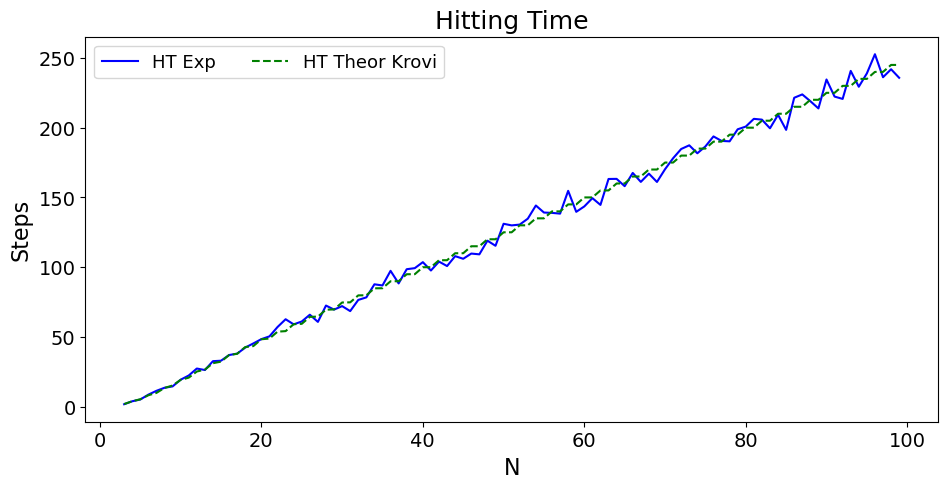

In [58]:
n_range = range(3, 100)

init = 0
target = 'mid'

cw_weight=0.6
acw_weight=0.4

theoretical_hitting_times = theoretical_hitting_times_for_cycle_graphs(n_range, init, target,cw_weight,acw_weight)
theoretical_hitting_times2 = theoretical_hitting_times_for_cycle_graphs2(n_range, init, target,cw_weight,acw_weight)
print(theoretical_hitting_times)
print()
print(theoretical_hitting_times2)
# 
# theoretical_hitting_times_file = f'Datasets/HTDirectedCycle/theoreticalHittingTimeDirectedCycle_N{n_range[-1]}_CWWEIGHT{cw_weight}_ACWWEIGHT{acw_weight}_FROM{initVertex}-TO{targetVertex}.txt'

# print(f'Looking for: \n-----> {theoretical_hitting_times_file}')

# if os.path.exists(theoretical_hitting_times_file):
#     theoretical_hitting_times = load_list_from_file(theoretical_hitting_times_file)
#     print('\nFile exists!')
# else:
#     print('\nFile Doesnt Exist!')
#     theoretical_hitting_times =  theoretical_hitting_times_for_cycle_graphs(n_range, init, target,cw_weight,acw_weight)
#     write_list_to_file(theoretical_hitting_times_file, theoretical_hitting_times)

alphaLabelList = [r'HT Exp',f'HT Theor Krovi']


params = {
    'font_size' : 14,
    'figsize': (11, 5),
    'plot_title' : f'Hitting Time',
    'x_label' : 'N',
    'y_label' : "Steps",
    'legend_labels' : alphaLabelList,
    'legend_loc': "best",
    # 'legend_title' : r'$\alpha$',
    'legend_ncol' : 2,
    'color_list' : ['#0000FF', '#008000', '#525252','red','#eb4034','#8f82f1'],
    'line_style_list' : ['-', '--','-.',':','-','-.'],
    # 'save_path' : f'Output/OrientedDynamics/orientedDynamics_N{N}_NWALKS{len(alphaList)}_Alphas{str([round(a, 2) for a in alphaList]).replace(", ", "-").replace("[", "").replace("]", "")}_TMAX{round(t)}.png',
    'use_loglog': False,
    'use_cbar' : False,
    'cbar_label' : None, 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'x_lim' : None,
}

y_value_list = [hitting_times3,
                theoretical_hitting_times,
               ]

print(len(hitting_times3))
print(len(theoretical_hitting_times))
plot_qwak(x_value_matrix = [list(n_range)]*2 , y_value_matrix = y_value_list ,**params)

Looking for: 
-----> Datasets/HTDirectedCycle/theoreticalHittingTimeDirectedCycle_N99_CWWEIGHT0.5_ACWWEIGHT0.5_FROM0-TOmid.txt

File exists!
97
97


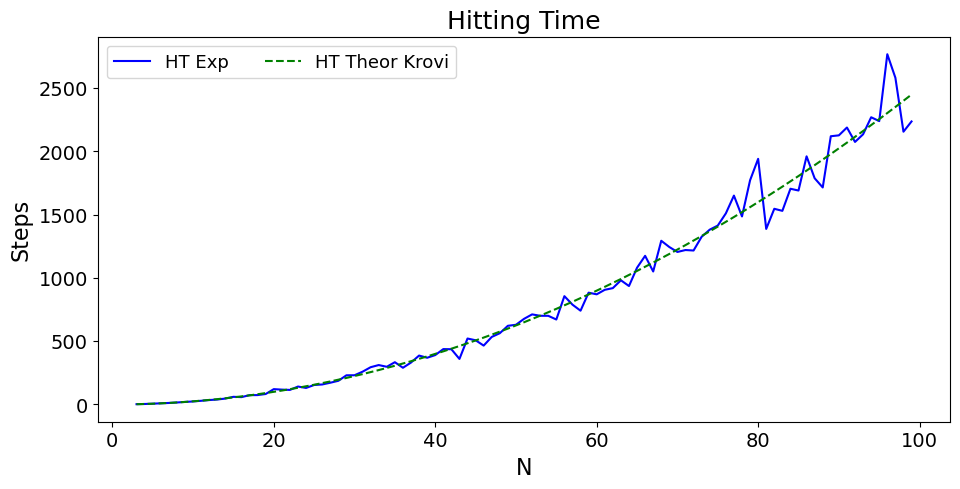

In [56]:
n_range = range(3, 100)

init = 0
target = 'mid'

cw_weight=0.5
acw_weight=0.5

# theoretical_hitting_times = theoretical_hitting_times_for_cycle_graphs(n_range, init, target,cw_weight,acw_weight)

theoretical_hitting_times_file = f'Datasets/HTDirectedCycle/theoreticalHittingTimeDirectedCycle_N{n_range[-1]}_CWWEIGHT{cw_weight}_ACWWEIGHT{acw_weight}_FROM{initVertex}-TO{targetVertex}.txt'

print(f'Looking for: \n-----> {theoretical_hitting_times_file}')

if os.path.exists(theoretical_hitting_times_file):
    theoretical_hitting_times = load_list_from_file(theoretical_hitting_times_file)
    print('\nFile exists!')
else:
    print('\nFile Doesnt Exist!')
    theoretical_hitting_times =  theoretical_hitting_times_for_cycle_graphs(n_range, init, target,cw_weight,acw_weight)
    write_list_to_file(theoretical_hitting_times_file, theoretical_hitting_times)

alphaLabelList = [r'HT Exp',f'HT Theor Krovi']


params = {
    'font_size' : 14,
    'figsize': (11, 5),
    'plot_title' : f'Hitting Time',
    'x_label' : 'N',
    'y_label' : "Steps",
    'legend_labels' : alphaLabelList,
    'legend_loc': "best",
    # 'legend_title' : r'$\alpha$',
    'legend_ncol' : 2,
    'color_list' : ['#0000FF', '#008000', '#525252','red','#eb4034','#8f82f1'],
    'line_style_list' : ['-', '--','-.',':','-','-.'],
    # 'save_path' : f'Output/OrientedDynamics/orientedDynamics_N{N}_NWALKS{len(alphaList)}_Alphas{str([round(a, 2) for a in alphaList]).replace(", ", "-").replace("[", "").replace("]", "")}_TMAX{round(t)}.png',
    'use_loglog': False,
    'use_cbar' : False,
    'cbar_label' : None, 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'x_lim' : None,
}

y_value_list = [hitting_times,
                theoretical_hitting_times,
               ]

print(len(hitting_times3))
print(len(theoretical_hitting_times))
plot_qwak(x_value_matrix = [list(n_range)]*2 , y_value_matrix = y_value_list ,**params)

Looking for: 
-----> Datasets/HTDirectedCycle/theoreticalHittingTimeDirectedCycle_N99_CWWEIGHT0.55_ACWWEIGHT0.45_FROM0-TOmid.txt

File exists!
97
97


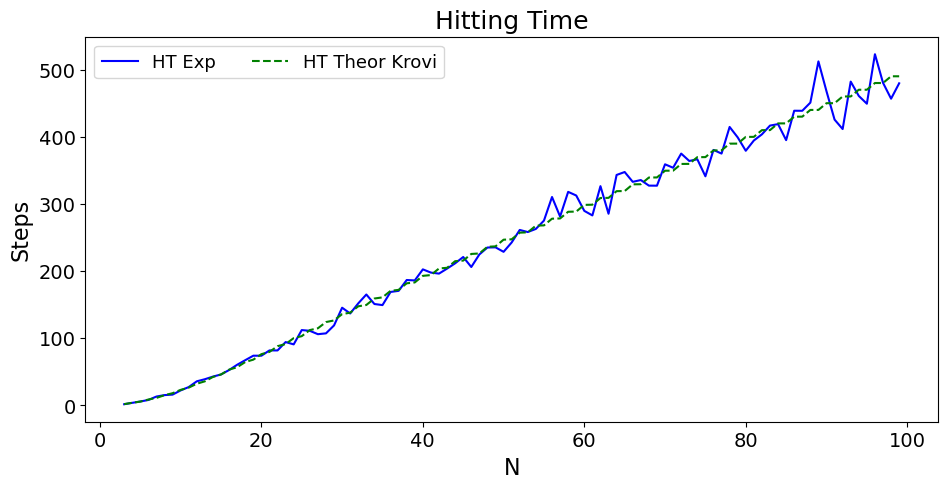

In [43]:
n_range = range(3, 100)

init = 0
target = 'mid'

cw_weight=0.55
acw_weight=0.45

# theoretical_hitting_times = theoretical_hitting_times_for_cycle_graphs(n_range, init, target,cw_weight,acw_weight)

theoretical_hitting_times_file = f'Datasets/HTDirectedCycle/theoreticalHittingTimeDirectedCycle_N{n_range[-1]}_CWWEIGHT{cw_weight}_ACWWEIGHT{acw_weight}_FROM{initVertex}-TO{targetVertex}.txt'

print(f'Looking for: \n-----> {theoretical_hitting_times_file}')

if os.path.exists(theoretical_hitting_times_file):
    theoretical_hitting_times = load_list_from_file(theoretical_hitting_times_file)
    print('\nFile exists!')
else:
    print('\nFile Doesnt Exist!')
    theoretical_hitting_times =  theoretical_hitting_times_for_cycle_graphs(n_range, init, target,cw_weight,acw_weight)
    write_list_to_file(theoretical_hitting_times_file, theoretical_hitting_times)

alphaLabelList = [r'HT Exp',f'HT Theor Krovi']


params = {
    'font_size' : 14,
    'figsize': (11, 5),
    'plot_title' : f'Hitting Time',
    'x_label' : 'N',
    'y_label' : "Steps",
    'legend_labels' : alphaLabelList,
    'legend_loc': "best",
    # 'legend_title' : r'$\alpha$',
    'legend_ncol' : 2,
    'color_list' : ['#0000FF', '#008000', '#525252','red','#eb4034','#8f82f1'],
    'line_style_list' : ['-', '--','-.',':','-','-.'],
    # 'save_path' : f'Output/OrientedDynamics/orientedDynamics_N{N}_NWALKS{len(alphaList)}_Alphas{str([round(a, 2) for a in alphaList]).replace(", ", "-").replace("[", "").replace("]", "")}_TMAX{round(t)}.png',
    'use_loglog': False,
    'use_cbar' : False,
    'cbar_label' : None, 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'x_lim' : None,
}

y_value_list = [hitting_times4,
                theoretical_hitting_times,
               ]

print(len(hitting_times3))
print(len(theoretical_hitting_times))
plot_qwak(x_value_matrix = [list(n_range)]*2 , y_value_matrix = y_value_list ,**params)

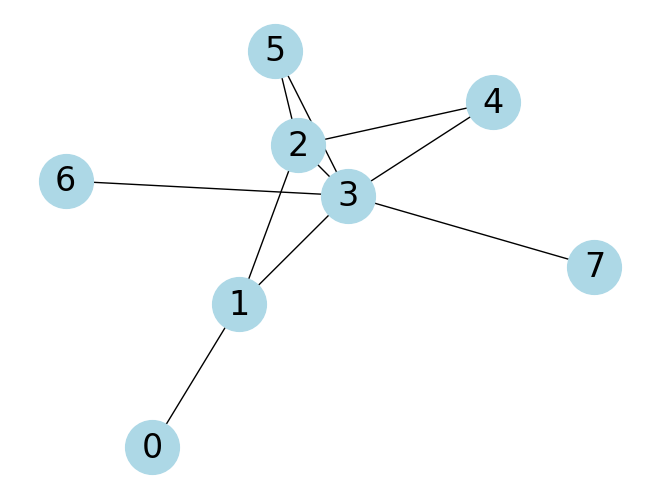

In [59]:
import networkx as nx
import matplotlib.pyplot as plt

def unique_edges_graph(n_nodes):
    """
    Create a graph with `n_nodes` where each node has a unique number of edges.
    
    Parameters:
    - n_nodes: Number of nodes in the graph
    
    Returns:
    - G: A networkx Graph
    """
    if n_nodes <= 1:
        raise ValueError("The number of nodes should be greater than 1.")

    G = nx.Graph()
    total_edges = n_nodes * (n_nodes - 1) // 2  # n(n-1)/2 is the total number of edges for a complete graph of n nodes
    
    if total_edges < sum(range(n_nodes)):  # The total edges of complete graph should be >= sum of first n integers to ensure uniqueness
        raise ValueError(f"Cannot create a graph with {n_nodes} nodes where each has a unique number of edges.")

    # Start building the graph
    current_node = 0
    for i in range(1, n_nodes):
        for j in range(i):
            G.add_edge(current_node, current_node + 1 + j)
        current_node += 1

    return G

# Example usage
G = unique_edges_graph(5)
nx.draw(G, with_labels=True, node_color='lightblue', node_size=1500, font_size=24)
plt.show()
